<a href="https://colab.research.google.com/github/kamilenovaes/machine-learning-python/blob/main/notebooks/05_Decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌳 Árvores de Decisão (Decision Trees)

**🎯 Objetivo:** treinar um modelo de **classificação** com *Decision Tree* para prever qual medicamento (“Drug”) deve ser recomendado a um paciente a partir de características clínicas.

- carregar e inspecionar o dataset `drug200`;
- preparar variáveis categóricas (transformar em números);
- treinar uma **árvore de decisão** (critério *entropy*);
- avaliar com **acurácia**;
- visualizar a árvore e interpretar regras.


## 1. Bibliotecas

In [ ]:
# (Opcional)
#!pip install -q numpy==2.2.0
#!pip install -q pandas==2.2.3
#!pip install -q scikit-learn==1.6.0
#!pip install -q matplotlib==3.9.3


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


## 2. Dataset

O dataset contém pacientes com a mesma doença, e cada um respondeu a **um** dentre 5 medicamentos:

- `drugA`, `drugB`, `drugC`, `drugX`, `drugY`  → **alvo (target)**: coluna `Drug`

As **features** (entradas) são:
- `Age` (idade)
- `Sex` (sexo)
- `BP` (pressão arterial)
- `Cholesterol`
- `Na_to_K` (razão sódio/potássio)


In [2]:
path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv"
my_data = pd.read_csv(path)

my_data.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


## 3. Inspeção rápida

Primeiro, checamos tipos de dados e se há colunas categóricas (texto) que precisem virar números.

In [3]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


## 4. Pré-processamento: transformar categorias em números

Modelos do scikit-learn trabalham com números. Aqui temos variáveis categóricas (`Sex`, `BP`, `Cholesterol`).

Vamos usar `LabelEncoder` (mapeia cada categoria para um inteiro).  

(Para alguns modelos, *One-Hot Encoding* pode ser melhor. Aqui, como é um laboratório e árvore de decisão lida razoavelmente bem com rótulos inteiros, seguimos com `LabelEncoder`.)

In [4]:
label_encoder = LabelEncoder()

my_data["Sex"] = label_encoder.fit_transform(my_data["Sex"])
my_data["BP"] = label_encoder.fit_transform(my_data["BP"])
my_data["Cholesterol"] = label_encoder.fit_transform(my_data["Cholesterol"])

my_data.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,drugY
1,47,1,1,0,13.093,drugC
2,47,1,1,0,10.114,drugC
3,28,0,2,0,7.798,drugX
4,61,0,1,0,18.043,drugY


Vamos checar se existem valores ausentes (missing values).

In [5]:
my_data.isnull().sum()

,0
Age,0
Sex,0
BP,0
Cholesterol,0
Na_to_K,0
Drug,0


## 5. Correlação (análise rápida)

Para calcular correlação, precisamos que o alvo também seja numérico.  
Esse mapeamento é **arbitrário** e serve apenas para *exploração* (não para treinar o modelo).

In [6]:
custom_map = {"drugA": 0, "drugB": 1, "drugC": 2, "drugX": 3, "drugY": 4}
my_data["Drug_num"] = my_data["Drug"].map(custom_map)

my_data.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Drug_num
0,23,0,0,0,25.355,drugY,4
1,47,1,1,0,13.093,drugC,2
2,47,1,1,0,10.114,drugC,2
3,28,0,2,0,7.798,drugX,3
4,61,0,1,0,18.043,drugY,4


Agora calculamos a correlação das features com `Drug_num`.

> Interpretação: valores com maior magnitude (positivo/negativo) tendem a variar mais “junto” do alvo numérico (lembrando que o alvo foi codificado de forma arbitrária). Serve como **pista**, não como verdade absoluta.

In [7]:
correlacoes = my_data.drop("Drug", axis=1).corr(numeric_only=True)["Drug_num"].sort_values(ascending=False)
correlacoes


,Drug_num
Drug_num,1.000000
Na_to_K,0.589120
BP,0.372868
Cholesterol,0.055629
Age,-0.004828
Sex,-0.098573


Em geral, neste dataset, `Na_to_K` costuma aparecer como uma das variáveis mais informativas.

## 6. Distribuição das classes

Ver a quantidade de exemplos por classe ajuda a entender se o dataset é desbalanceado.

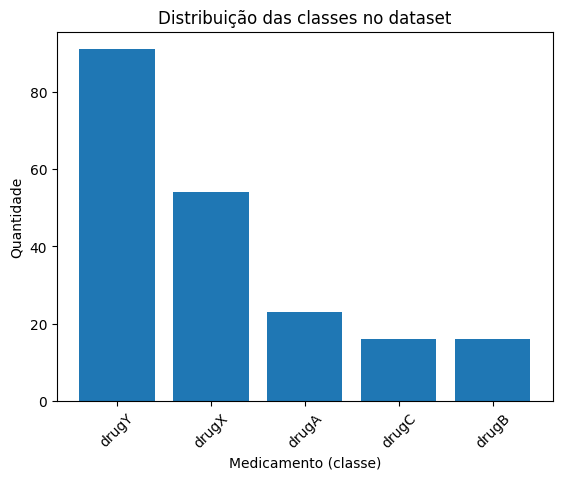

In [8]:
category_counts = my_data["Drug"].value_counts()

plt.bar(category_counts.index, category_counts.values)
plt.xlabel("Medicamento (classe)")
plt.ylabel("Quantidade")
plt.title("Distribuição das classes no dataset")
plt.xticks(rotation=45)
plt.show()


## 7. Modelagem: Treinando a Árvore de Decisão

1. Separar `X` (features) e `y` (alvo).
2. Dividir em treino/teste.
3. Treinar a árvore com critério **entropy** (equivalente a maximizar ganho de informação).

In [9]:
y = my_data["Drug"]
X = my_data.drop(["Drug", "Drug_num"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=32
)

X_train.shape, X_test.shape


((140, 5), (60, 5))

In [10]:
# Treina uma árvore com profundidade máxima 4 (hiperparâmetro que controla complexidade)
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=32)
drugTree.fit(X_train, y_train)

pred = drugTree.predict(X_test)
acc = metrics.accuracy_score(y_test, pred)

print(f"Acurácia (max_depth=4): {acc:.4f}")


Acurácia (max_depth=4): 0.9833


## 8. Visualização e interpretação

A árvore vira um conjunto de regras do tipo:

> “se `Na_to_K` > limite, então ... senão ...”

Vamos plotar a árvore para enxergar essas decisões.

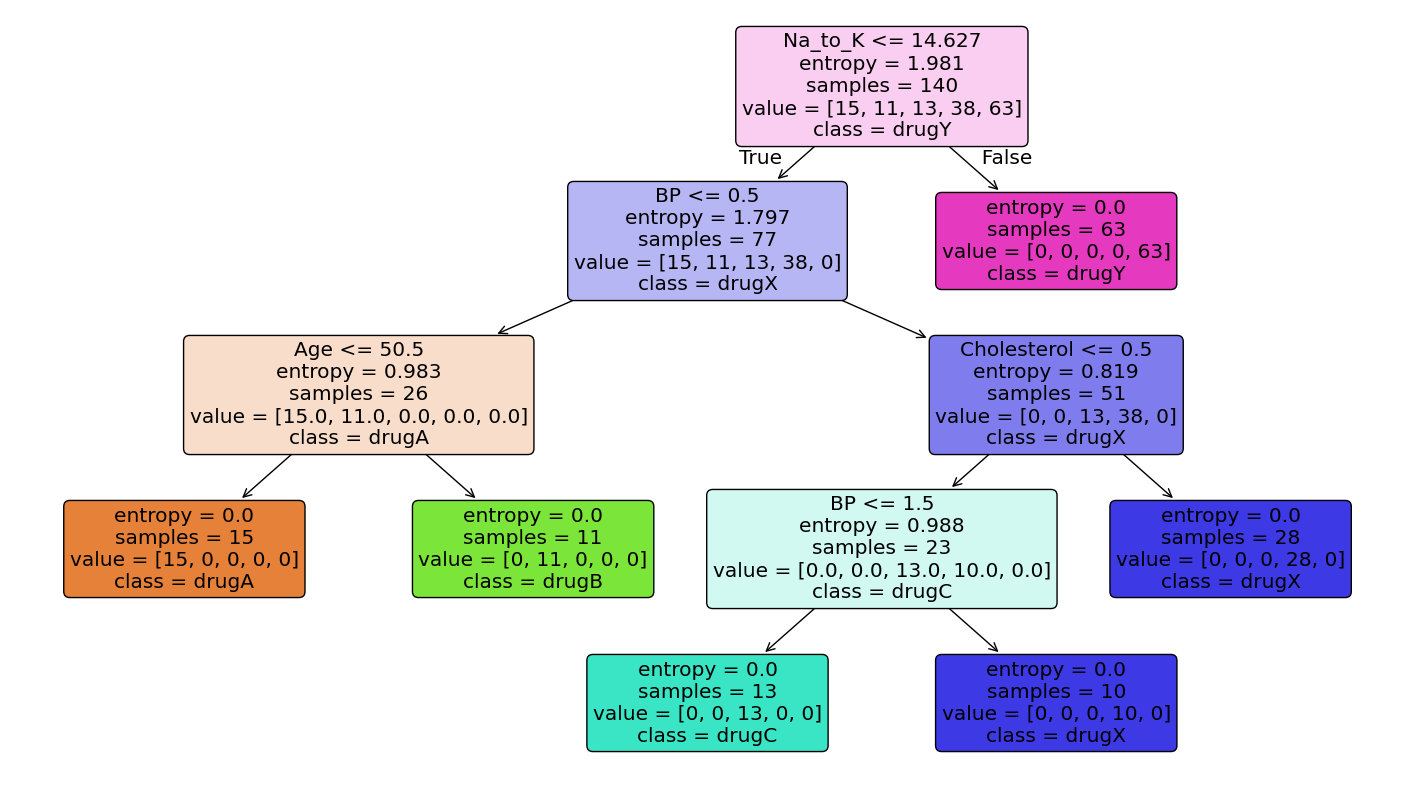

In [11]:
plt.figure(figsize=(18, 10))
plot_tree(
    drugTree,
    feature_names=X.columns,
    class_names=sorted(y.unique()),
    filled=True,
    rounded=True,
    impurity=True
)
plt.show()


### 8.1. Regras (exemplo)

Ao “seguir” um caminho da raiz até uma folha, você obtém uma regra de decisão.

Exemplo citado no lab: **Drug Y** ocorre quando `Na_to_K > 14.627`.

Outras regras típicas (podem variar um pouco dependendo do treinamento/plot):
- **Drug A:** `Na_to_K ≤ 14.627`, `BP = High`, `Age ≤ 50.5`
- **Drug B:** `Na_to_K ≤ 14.627`, `BP = High`, `Age > 50.5`
- **Drug C:** `Na_to_K ≤ 14.627`, `BP = Low`, `Cholesterol ≤ High`
- **Drug X:** `Na_to_K ≤ 14.627`, `BP = Normal`, `Cholesterol = High`

> Observação: esses “limites” vêm do particionamento aprendido pela árvore a partir dos dados de treino.

## 9. E se reduzirmos a profundidade?

Diminuir `max_depth` tende a:
- **reduzir overfitting** (árvore menos “decoradora” dos dados),
- mas pode **aumentar underfitting** (modelo simples demais).

Vamos comparar rapidamente `max_depth=4` vs `max_depth=3`.

In [12]:
def avaliar_arvore(max_depth: int) -> float:
    model = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=32)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return metrics.accuracy_score(y_test, pred)

acc_d4 = avaliar_arvore(4)
acc_d3 = avaliar_arvore(3)

print(f"Acurácia (max_depth=4): {acc_d4:.4f}")
print(f"Acurácia (max_depth=3): {acc_d3:.4f}")


Acurácia (max_depth=4): 0.9833
Acurácia (max_depth=3): 0.8167
